In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-3:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1777 - acc: 0.3405
Epoch 00001: val_loss improved from inf to 2.19247, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_3_conv_checkpoint/001-2.1925.hdf5
36805/36805 [==============================] - 32s 856us/sample - loss: 2.1777 - acc: 0.3405 - val_loss: 2.1925 - val_acc: 0.3229
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7293 - acc: 0.4791
Epoch 00002: val_loss improved from 2.19247 to 1.72190, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_3_conv_checkpoint/002-1.7219.hdf5
36805/36805 [==============================] - 28s 770us/sample - loss: 1.7294 - acc: 0.4791 - val_loss: 1.7219 - val_acc: 0.4854
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5429 - acc: 0.5438
Epoch 00003: val_loss did not improve from 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9161 - acc: 0.7325
Epoch 00026: val_loss did not improve from 1.06739
36805/36805 [==============================] - 28s 760us/sample - loss: 0.9161 - acc: 0.7325 - val_loss: 1.3371 - val_acc: 0.5679
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9061 - acc: 0.7292
Epoch 00027: val_loss did not improve from 1.06739
36805/36805 [==============================] - 28s 759us/sample - loss: 0.9062 - acc: 0.7292 - val_loss: 1.4922 - val_acc: 0.5313
Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9012 - acc: 0.7342
Epoch 00028: val_loss did not improve from 1.06739
36805/36805 [==============================] - 28s 760us/sample - loss: 0.9013 - acc: 0.7341 - val_loss: 1.4059 - val_acc: 0.5702
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8919 - acc: 0.7344
Epoch 00029: val_loss did not improve from 1.06739
36805/36805 [=====

Epoch 55/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7797 - acc: 0.7678
Epoch 00055: val_loss did not improve from 0.88387
36805/36805 [==============================] - 28s 761us/sample - loss: 0.7803 - acc: 0.7677 - val_loss: 1.2426 - val_acc: 0.6308
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7793 - acc: 0.7677
Epoch 00056: val_loss did not improve from 0.88387
36805/36805 [==============================] - 28s 759us/sample - loss: 0.7790 - acc: 0.7678 - val_loss: 0.9703 - val_acc: 0.7086
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7766 - acc: 0.7705
Epoch 00057: val_loss improved from 0.88387 to 0.78613, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_3_conv_checkpoint/057-0.7861.hdf5
36805/36805 [==============================] - 28s 760us/sample - loss: 0.7768 - acc: 0.7704 - val_loss: 0.7861 - val_acc: 0.7775
Epoch 58/500
36736/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.7195 - acc: 0.7875
Epoch 00084: val_loss did not improve from 0.78613
36805/36805 [==============================] - 28s 760us/sample - loss: 0.7195 - acc: 0.7875 - val_loss: 3.8905 - val_acc: 0.3072
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7144 - acc: 0.7887
Epoch 00085: val_loss did not improve from 0.78613
36805/36805 [==============================] - 28s 765us/sample - loss: 0.7144 - acc: 0.7887 - val_loss: 1.2387 - val_acc: 0.6469
Epoch 86/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7111 - acc: 0.7888
Epoch 00086: val_loss did not improve from 0.78613
36805/36805 [==============================] - 28s 759us/sample - loss: 0.7109 - acc: 0.7889 - val_loss: 1.7494 - val_acc: 0.5097
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7130 - acc: 0.7884
Epoch 00087: val_loss did not improve from 0.78613
36805/36805 [==================

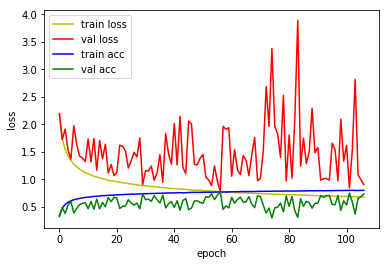

4815/4815 [==============================] - 2s 380us/sample - loss: 0.8552 - acc: 0.7443
Loss: 0.8551614138691349 Accuracy: 0.7443406

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.0436 - acc: 0.3812
Epoch 00001: val_loss improved from inf to 2.13253, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_4_conv_checkpoint/001-2.1325.hdf5
36805/36805 [==============================] - 33s 891us/sample - loss: 2.0431 - acc: 0.3814 - val_loss: 2.1325 - val_acc: 0.2509
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5543 - acc: 0.5349
Epoch 00002: val_loss improved from 2.13253 to 1.50920, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_4_conv_checkpoint/002-1.5092.hdf5
36805/36805 [==============================] - 29s 777us/sample - loss: 1.5543 - acc: 0.5349 - val_loss: 1.5092 - val_acc: 0.5362
Epoch 3/500
36736/36805 [==========================

Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7384 - acc: 0.7843
Epoch 00027: val_loss did not improve from 0.88195
36805/36805 [==============================] - 29s 775us/sample - loss: 0.7389 - acc: 0.7842 - val_loss: 1.2211 - val_acc: 0.6389
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7369 - acc: 0.7843
Epoch 00028: val_loss did not improve from 0.88195
36805/36805 [==============================] - 29s 775us/sample - loss: 0.7368 - acc: 0.7844 - val_loss: 1.0439 - val_acc: 0.6811
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7286 - acc: 0.7907
Epoch 00029: val_loss did not improve from 0.88195
36805/36805 [==============================] - 28s 772us/sample - loss: 0.7281 - acc: 0.7907 - val_loss: 1.5431 - val_acc: 0.5304
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7200 - acc: 0.7900
Epoch 00030: val_loss did not improve from 0.88195
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.6031 - acc: 0.8261
Epoch 00056: val_loss did not improve from 0.78562
36805/36805 [==============================] - 28s 773us/sample - loss: 0.6031 - acc: 0.8261 - val_loss: 0.9387 - val_acc: 0.7338
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5994 - acc: 0.8271
Epoch 00057: val_loss improved from 0.78562 to 0.76980, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_4_conv_checkpoint/057-0.7698.hdf5
36805/36805 [==============================] - 28s 774us/sample - loss: 0.5995 - acc: 0.8271 - val_loss: 0.7698 - val_acc: 0.7722
Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5913 - acc: 0.8285
Epoch 00058: val_loss improved from 0.76980 to 0.73899, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_4_conv_checkpoint/058-0.7390.hdf5
36805/36805 [==============================] - 28s 770us/sample - loss: 0.5914 - acc: 0.8284 - 

Epoch 85/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5207 - acc: 0.8484
Epoch 00085: val_loss did not improve from 0.72712
36805/36805 [==============================] - 29s 775us/sample - loss: 0.5206 - acc: 0.8483 - val_loss: 1.0341 - val_acc: 0.7137
Epoch 86/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5167 - acc: 0.8509
Epoch 00086: val_loss did not improve from 0.72712
36805/36805 [==============================] - 28s 771us/sample - loss: 0.5165 - acc: 0.8509 - val_loss: 1.2608 - val_acc: 0.6445
Epoch 87/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5135 - acc: 0.8515
Epoch 00087: val_loss did not improve from 0.72712
36805/36805 [==============================] - 28s 769us/sample - loss: 0.5134 - acc: 0.8515 - val_loss: 1.0917 - val_acc: 0.6837
Epoch 88/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5121 - acc: 0.8533
Epoch 00088: val_loss did not improve from 0.72712
36805/36805 [=====

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4644 - acc: 0.8649
Epoch 00114: val_loss did not improve from 0.62241
36805/36805 [==============================] - 28s 772us/sample - loss: 0.4644 - acc: 0.8650 - val_loss: 0.7023 - val_acc: 0.7997
Epoch 115/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4569 - acc: 0.8667
Epoch 00115: val_loss did not improve from 0.62241
36805/36805 [==============================] - 29s 778us/sample - loss: 0.4575 - acc: 0.8665 - val_loss: 1.6297 - val_acc: 0.6392
Epoch 116/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4614 - acc: 0.8657
Epoch 00116: val_loss did not improve from 0.62241
36805/36805 [==============================] - 28s 770us/sample - loss: 0.4616 - acc: 0.8658 - val_loss: 1.0570 - val_acc: 0.6962
Epoch 117/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4551 - acc: 0.8670
Epoch 00117: val_loss did not improve from 0.62241
36805/36805 [=

Epoch 144/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4132 - acc: 0.8802
Epoch 00144: val_loss did not improve from 0.62241
36805/36805 [==============================] - 28s 771us/sample - loss: 0.4131 - acc: 0.8802 - val_loss: 0.9414 - val_acc: 0.7419
Epoch 145/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4177 - acc: 0.8776
Epoch 00145: val_loss did not improve from 0.62241
36805/36805 [==============================] - 28s 773us/sample - loss: 0.4178 - acc: 0.8775 - val_loss: 0.6625 - val_acc: 0.8178
Epoch 146/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4170 - acc: 0.8782
Epoch 00146: val_loss did not improve from 0.62241
36805/36805 [==============================] - 28s 771us/sample - loss: 0.4174 - acc: 0.8783 - val_loss: 0.8884 - val_acc: 0.7647
Epoch 147/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4173 - acc: 0.8772
Epoch 00147: val_loss did not improve from 0.62241
36805/36805 [=

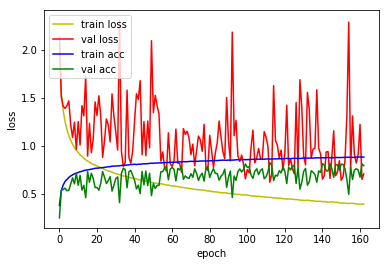

4815/4815 [==============================] - 2s 385us/sample - loss: 0.7048 - acc: 0.7981
Loss: 0.7048168689910002 Accuracy: 0.79813087

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8906 - acc: 0.4316
Epoch 00001: val_loss improved from inf to 1.82372, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_5_conv_checkpoint/001-1.8237.hdf5
36805/36805 [==============================] - 36s 967us/sample - loss: 1.8906 - acc: 0.4317 - val_loss: 1.8237 - val_acc: 0.4456
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3242 - acc: 0.6129
Epoch 00002: val_loss improved from 1.82372 to 1.23849, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_5_conv_checkpoint/002-1.2385.hdf5
36805/36805 [==============================] - 30s 808us/sample - loss: 1.3241 - acc: 0.6129 - val_loss: 1.2385 - val_acc: 0.6508
Epoch 3/500
36800/36805 [=========================

Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4216 - acc: 0.8832
Epoch 00025: val_loss did not improve from 0.51016
36805/36805 [==============================] - 30s 810us/sample - loss: 0.4215 - acc: 0.8833 - val_loss: 0.5704 - val_acc: 0.8314
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4138 - acc: 0.8830
Epoch 00026: val_loss improved from 0.51016 to 0.44782, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_5_conv_checkpoint/026-0.4478.hdf5
36805/36805 [==============================] - 29s 800us/sample - loss: 0.4137 - acc: 0.8830 - val_loss: 0.4478 - val_acc: 0.8777
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4044 - acc: 0.8868
Epoch 00027: val_loss did not improve from 0.44782
36805/36805 [==============================] - 30s 805us/sample - loss: 0.4040 - acc: 0.8870 - val_loss: 0.4873 - val_acc: 0.8637
Epoch 28/500
36800/36805 [============================>.] -

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2703 - acc: 0.9236
Epoch 00052: val_loss did not improve from 0.35585
36805/36805 [==============================] - 30s 803us/sample - loss: 0.2703 - acc: 0.9236 - val_loss: 0.3663 - val_acc: 0.8980
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2654 - acc: 0.9245
Epoch 00053: val_loss did not improve from 0.35585
36805/36805 [==============================] - 30s 809us/sample - loss: 0.2654 - acc: 0.9245 - val_loss: 0.4176 - val_acc: 0.8742
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2650 - acc: 0.9243
Epoch 00054: val_loss did not improve from 0.35585
36805/36805 [==============================] - 30s 807us/sample - loss: 0.2650 - acc: 0.9243 - val_loss: 0.4295 - val_acc: 0.8758
Epoch 55/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2617 - acc: 0.9264
Epoch 00055: val_loss did not improve from 0.35585
36805/36805 [=====

36736/36805 [============================>.] - ETA: 0s - loss: 0.1948 - acc: 0.9436
Epoch 00080: val_loss did not improve from 0.33291
36805/36805 [==============================] - 30s 805us/sample - loss: 0.1948 - acc: 0.9435 - val_loss: 0.3686 - val_acc: 0.8912
Epoch 81/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1916 - acc: 0.9454
Epoch 00081: val_loss did not improve from 0.33291
36805/36805 [==============================] - 30s 804us/sample - loss: 0.1917 - acc: 0.9454 - val_loss: 0.3430 - val_acc: 0.9050
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1911 - acc: 0.9455
Epoch 00082: val_loss improved from 0.33291 to 0.33111, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_5_conv_checkpoint/082-0.3311.hdf5
36805/36805 [==============================] - 30s 813us/sample - loss: 0.1911 - acc: 0.9454 - val_loss: 0.3311 - val_acc: 0.9075
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.1480 - acc: 0.9567
Epoch 00108: val_loss improved from 0.32036 to 0.31706, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_5_conv_checkpoint/108-0.3171.hdf5
36805/36805 [==============================] - 30s 802us/sample - loss: 0.1481 - acc: 0.9567 - val_loss: 0.3171 - val_acc: 0.9171
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1437 - acc: 0.9578
Epoch 00109: val_loss did not improve from 0.31706
36805/36805 [==============================] - 29s 799us/sample - loss: 0.1439 - acc: 0.9577 - val_loss: 0.3341 - val_acc: 0.9106
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1470 - acc: 0.9565
Epoch 00110: val_loss did not improve from 0.31706
36805/36805 [==============================] - 30s 804us/sample - loss: 0.1471 - acc: 0.9564 - val_loss: 0.3375 - val_acc: 0.9108
Epoch 111/500
36736/36805 [============================>.] - ETA: 0s -

Epoch 137/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1124 - acc: 0.9683
Epoch 00137: val_loss did not improve from 0.31706
36805/36805 [==============================] - 30s 803us/sample - loss: 0.1125 - acc: 0.9682 - val_loss: 0.4541 - val_acc: 0.8880
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.9689
Epoch 00138: val_loss did not improve from 0.31706
36805/36805 [==============================] - 30s 808us/sample - loss: 0.1101 - acc: 0.9689 - val_loss: 0.4343 - val_acc: 0.8928
Epoch 139/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1064 - acc: 0.9697
Epoch 00139: val_loss did not improve from 0.31706
36805/36805 [==============================] - 30s 802us/sample - loss: 0.1063 - acc: 0.9697 - val_loss: 0.4199 - val_acc: 0.9012
Epoch 140/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1059 - acc: 0.9701
Epoch 00140: val_loss did not improve from 0.31706
36805/36805 [=

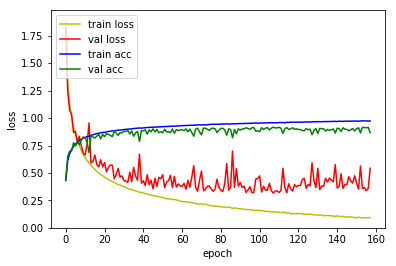

4815/4815 [==============================] - 2s 422us/sample - loss: 0.3709 - acc: 0.8860
Loss: 0.37090363464127696 Accuracy: 0.8859813

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6769 - acc: 0.4949
Epoch 00001: val_loss improved from inf to 1.65198, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_6_conv_checkpoint/001-1.6520.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 1.6769 - acc: 0.4949 - val_loss: 1.6520 - val_acc: 0.4843
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0530 - acc: 0.7061
Epoch 00002: val_loss improved from 1.65198 to 0.94194, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_6_conv_checkpoint/002-0.9419.hdf5
36805/36805 [==============================] - 31s 840us/sample - loss: 1.0531 - acc: 0.7061 - val_loss: 0.9419 - val_acc: 0.7193
Epoch 3/500
36800/36805 [===========================

Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1980 - acc: 0.9422
Epoch 00024: val_loss improved from 0.25139 to 0.24324, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_6_conv_checkpoint/024-0.2432.hdf5
36805/36805 [==============================] - 31s 844us/sample - loss: 0.1982 - acc: 0.9421 - val_loss: 0.2432 - val_acc: 0.9276
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1921 - acc: 0.9461
Epoch 00025: val_loss did not improve from 0.24324
36805/36805 [==============================] - 31s 839us/sample - loss: 0.1923 - acc: 0.9460 - val_loss: 0.2770 - val_acc: 0.9161
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1858 - acc: 0.9478
Epoch 00026: val_loss did not improve from 0.24324
36805/36805 [==============================] - 31s 836us/sample - loss: 0.1858 - acc: 0.9478 - val_loss: 0.2444 - val_acc: 0.9259
Epoch 27/500
36800/36805 [============================>.] -

Epoch 51/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0904 - acc: 0.9756
Epoch 00051: val_loss did not improve from 0.22709
36805/36805 [==============================] - 31s 837us/sample - loss: 0.0904 - acc: 0.9756 - val_loss: 0.2380 - val_acc: 0.9341
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0906 - acc: 0.9740
Epoch 00052: val_loss did not improve from 0.22709
36805/36805 [==============================] - 31s 832us/sample - loss: 0.0906 - acc: 0.9739 - val_loss: 0.2351 - val_acc: 0.9320
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9766
Epoch 00053: val_loss did not improve from 0.22709
36805/36805 [==============================] - 31s 830us/sample - loss: 0.0849 - acc: 0.9766 - val_loss: 0.2275 - val_acc: 0.9329
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0807 - acc: 0.9784
Epoch 00054: val_loss did not improve from 0.22709
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9881
Epoch 00080: val_loss did not improve from 0.22277
36805/36805 [==============================] - 31s 850us/sample - loss: 0.0460 - acc: 0.9881 - val_loss: 0.2701 - val_acc: 0.9308
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9904
Epoch 00081: val_loss did not improve from 0.22277
36805/36805 [==============================] - 31s 839us/sample - loss: 0.0401 - acc: 0.9903 - val_loss: 0.2666 - val_acc: 0.9329
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9879
Epoch 00082: val_loss did not improve from 0.22277
36805/36805 [==============================] - 31s 834us/sample - loss: 0.0458 - acc: 0.9879 - val_loss: 0.2664 - val_acc: 0.9266
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9903
Epoch 00083: val_loss did not improve from 0.22277
36805/36805 [==================

Epoch 110/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9934
Epoch 00110: val_loss did not improve from 0.22277
36805/36805 [==============================] - 30s 826us/sample - loss: 0.0268 - acc: 0.9933 - val_loss: 0.3228 - val_acc: 0.9278
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9939
Epoch 00111: val_loss did not improve from 0.22277
36805/36805 [==============================] - 30s 824us/sample - loss: 0.0267 - acc: 0.9939 - val_loss: 0.2627 - val_acc: 0.9364

1D_CNN_custom_multi_3_GAP_ch_32_BN_6_conv Model


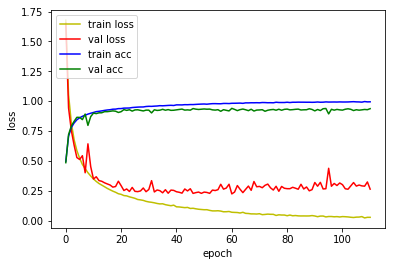

4815/4815 [==============================] - 2s 483us/sample - loss: 0.2754 - acc: 0.9252
Loss: 0.2753885194272391 Accuracy: 0.92523366

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4730 - acc: 0.5617
Epoch 00001: val_loss improved from inf to 1.27073, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_7_conv_checkpoint/001-1.2707.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.4730 - acc: 0.5617 - val_loss: 1.2707 - val_acc: 0.6345
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8105 - acc: 0.7757
Epoch 00002: val_loss improved from 1.27073 to 0.67689, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_7_conv_checkpoint/002-0.6769.hdf5
36805/36805 [==============================] - 32s 878us/sample - loss: 0.8106 - acc: 0.7757 - val_loss: 0.6769 - val_acc: 0.8104
Epoch 3/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9734
Epoch 00025: val_loss improved from 0.19738 to 0.19447, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_7_conv_checkpoint/025-0.1945.hdf5
36805/36805 [==============================] - 32s 875us/sample - loss: 0.0975 - acc: 0.9734 - val_loss: 0.1945 - val_acc: 0.9371
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0901 - acc: 0.9760
Epoch 00026: val_loss did not improve from 0.19447
36805/36805 [==============================] - 32s 873us/sample - loss: 0.0901 - acc: 0.9760 - val_loss: 0.2059 - val_acc: 0.9390
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0877 - acc: 0.9761
Epoch 00027: val_loss improved from 0.19447 to 0.18977, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_7_conv_checkpoint/027-0.1898.hdf5
36805/36805 [==============================] - 32s 881us/sample - loss: 0.0878 - acc: 0.9761 - 

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9937
Epoch 00054: val_loss did not improve from 0.18969
36805/36805 [==============================] - 32s 876us/sample - loss: 0.0280 - acc: 0.9938 - val_loss: 0.2332 - val_acc: 0.9418
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9960
Epoch 00055: val_loss did not improve from 0.18969
36805/36805 [==============================] - 32s 861us/sample - loss: 0.0215 - acc: 0.9959 - val_loss: 0.2605 - val_acc: 0.9355
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9909
Epoch 00056: val_loss did not improve from 0.18969
36805/36805 [==============================] - 32s 860us/sample - loss: 0.0373 - acc: 0.9909 - val_loss: 0.2319 - val_acc: 0.9383
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9937
Epoch 00057: val_loss did not improve from 0.18969
36805/36805 [=====

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0205 - acc: 0.9949
Epoch 00084: val_loss did not improve from 0.18969
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0205 - acc: 0.9949 - val_loss: 0.2446 - val_acc: 0.9429
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9982
Epoch 00085: val_loss did not improve from 0.18969
36805/36805 [==============================] - 32s 865us/sample - loss: 0.0106 - acc: 0.9982 - val_loss: 0.2351 - val_acc: 0.9457
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9986
Epoch 00086: val_loss did not improve from 0.18969
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0093 - acc: 0.9986 - val_loss: 0.2911 - val_acc: 0.9383
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9949
Epoch 00087: val_loss did not improve from 0.18969
36805/36805 [=====

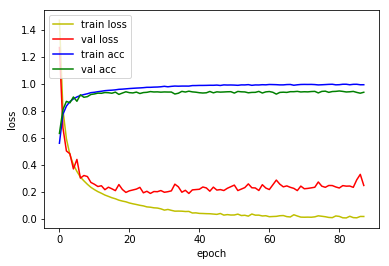

4815/4815 [==============================] - 2s 485us/sample - loss: 0.2501 - acc: 0.9300
Loss: 0.25009127608959797 Accuracy: 0.9300104

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5330 - acc: 0.5314
Epoch 00001: val_loss improved from inf to 1.51663, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_8_conv_checkpoint/001-1.5166.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.5329 - acc: 0.5314 - val_loss: 1.5166 - val_acc: 0.5101
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7422 - acc: 0.7886
Epoch 00002: val_loss improved from 1.51663 to 0.56937, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_BN_8_conv_checkpoint/002-0.5694.hdf5
36805/36805 [==============================] - 33s 908us/sample - loss: 0.7422 - acc: 0.7886 - val_loss: 0.5694 - val_acc: 0.8444
Epoch 3/500
36800/36805 [===========================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9863
Epoch 00025: val_loss did not improve from 0.17567
36805/36805 [==============================] - 33s 902us/sample - loss: 0.0544 - acc: 0.9863 - val_loss: 0.1872 - val_acc: 0.9429
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0531 - acc: 0.9858
Epoch 00026: val_loss did not improve from 0.17567
36805/36805 [==============================] - 33s 909us/sample - loss: 0.0532 - acc: 0.9858 - val_loss: 0.2025 - val_acc: 0.9362
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9872
Epoch 00027: val_loss did not improve from 0.17567
36805/36805 [==============================] - 33s 903us/sample - loss: 0.0514 - acc: 0.9872 - val_loss: 0.1945 - val_acc: 0.9387
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9878
Epoch 00028: val_loss did not improve from 0.17567
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9978
Epoch 00055: val_loss did not improve from 0.17567
36805/36805 [==============================] - 33s 907us/sample - loss: 0.0115 - acc: 0.9977 - val_loss: 0.2305 - val_acc: 0.9443
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9958
Epoch 00056: val_loss did not improve from 0.17567
36805/36805 [==============================] - 33s 901us/sample - loss: 0.0169 - acc: 0.9958 - val_loss: 0.1990 - val_acc: 0.9506
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9948
Epoch 00057: val_loss did not improve from 0.17567
36805/36805 [==============================] - 33s 898us/sample - loss: 0.0215 - acc: 0.9947 - val_loss: 0.1961 - val_acc: 0.9525
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9957
Epoch 00058: val_loss did not improve from 0.17567
36805/36805 [=====

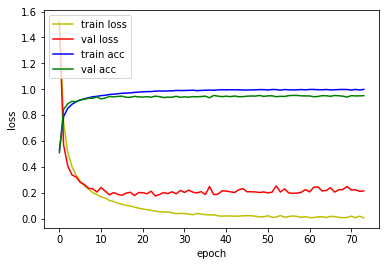

4815/4815 [==============================] - 3s 529us/sample - loss: 0.2623 - acc: 0.9261
Loss: 0.26232732015111615 Accuracy: 0.9260644



In [10]:
base = '1D_CNN_custom_multi_3_GAP_ch_32_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GAP_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GAP_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
____________________________________________________________

4815/4815 [==============================] - 3s 525us/sample - loss: 0.7048 - acc: 0.7981
Loss: 0.7048168689910002 Accuracy: 0.79813087

1D_CNN_custom_multi_3_GAP_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activati

4815/4815 [==============================] - 3s 592us/sample - loss: 0.2754 - acc: 0.9252
Loss: 0.2753885194272391 Accuracy: 0.92523366

1D_CNN_custom_multi_3_GAP_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activati

4815/4815 [==============================] - 3s 633us/sample - loss: 0.2623 - acc: 0.9261
Loss: 0.26232732015111615 Accuracy: 0.9260644


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_GAP_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
____________________________________________________________

4815/4815 [==============================] - 3s 620us/sample - loss: 0.8263 - acc: 0.7607
Loss: 0.826322969704526 Accuracy: 0.7607477

1D_CNN_custom_multi_3_GAP_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation

4815/4815 [==============================] - 3s 677us/sample - loss: 0.3188 - acc: 0.9234
Loss: 0.318825320322318 Accuracy: 0.92336446

1D_CNN_custom_multi_3_GAP_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activatio

4815/4815 [==============================] - 4s 765us/sample - loss: 0.3095 - acc: 0.9315
Loss: 0.3094815848079952 Accuracy: 0.9314642
